In [1]:
import sys
print(f"Python Version: {sys.version}")
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
#TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
#Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
#Display settings
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
print("\n" + "="*80)
print("✅ All libraries imported successfully!")
print("="*80)
print(f"TensorFlow Version: {tf.version}")
print(f"Keras Version: {keras.version}")

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

✅ All libraries imported successfully!
TensorFlow Version: <module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.12/dist-packages/tensorflow/_api/v2/version/__init__.py'>
Keras Version: <function version at 0x7c700d5a2340>


In [4]:
# ============================================================================
# Extract flowers.zip
# ============================================================================
import zipfile
import os

print("="*80)
print("EXTRACTING FLOWERS.ZIP")
print("="*80)

# Your ZIP file name
zip_filename = 'flowers.zip'
zip_path = f'/content/{zip_filename}'

# Check if the file exists
if os.path.exists(zip_path):
    print(f"Found: {zip_filename}")

    # Extract it
    print(f"\nExtracting {zip_filename}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')

    print("Extraction complete!")

    # Check what was extracted
    print("\nChecking extracted contents...")
    contents = os.listdir('/content/')
    print(f"\nAll items in /content/:")
    for item in contents:
        print(f"  - {item}")

    # Find the flowers folder
    print("\nLooking for flowers folder...")

    possible_paths = [
        '/content/flowers',
        '/content/flowers-recognition',
        '/content/archive',
        '/content/flower'
    ]

    DATA_PATH = None

    # Check common paths first
    for path in possible_paths:
        if os.path.exists(path):
            items = os.listdir(path)
            print(f"\nChecking: {path}")
            print(f"   Contents: {items[:10]}")  # Show first 10 items

            # Check if this folder has the flower subfolders
            if 'daisy' in items or 'rose' in items or 'tulip' in items:
                DATA_PATH = path
                print(f"\nFOUND FLOWERS DATASET!")
                break

    # If not found, search all directories
    if DATA_PATH is None:
        print("\nSearching all directories...")
        for item in os.listdir('/content/'):
            item_path = f'/content/{item}'
            if os.path.isdir(item_path) and item != 'sample_data':
                try:
                    sub_items = os.listdir(item_path)
                    print(f"\n  Checking {item_path}:")
                    print(f"    Contents: {sub_items[:5]}")

                    if 'daisy' in sub_items or 'rose' in sub_items or 'tulip' in sub_items:
                        DATA_PATH = item_path
                        print(f"\nFOUND FLOWERS DATASET!")
                        break
                except Exception as e:
                    pass

    # Final verification
    if DATA_PATH:
        print("\n" + "="*80)
        print("DATASET READY!")
        print("="*80)
        print(f"Dataset Location: {DATA_PATH}")

        # Count images in each folder
        FLOWER_CLASSES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
        print("\nImage counts per class:")
        total_images = 0
        for flower in FLOWER_CLASSES:
            flower_path = os.path.join(DATA_PATH, flower)
            if os.path.exists(flower_path):
                images = [f for f in os.listdir(flower_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                count = len(images)
                total_images += count
                print(f"  {flower.capitalize()}: {count} images")
            else:
                print(f"  {flower.capitalize()}: folder not found")

        print(f"\nTotal images: {total_images}")
        print("\n" + "="*80)
        print("You can now proceed to load the data!")
        print("="*80)

    else:
        print("\n" + "="*80)
        print("FLOWERS FOLDER NOT FOUND!")
        print("="*80)
        print("\nPlease check manually:")
        print("1. Look at the extracted contents above")
        print("2. Find which folder contains: daisy, dandelion, rose, sunflower, tulip")
        print("3. Set DATA_PATH manually in the next cell")

else:
    print(f"Error: {zip_filename} not found in /content/")
    print("\nPlease make sure you uploaded flowers.zip")
    print("\nCurrent files in /content/:")
    for item in os.listdir('/content/'):
        print(f"  - {item}")

EXTRACTING FLOWERS.ZIP
Found: flowers.zip

Extracting flowers.zip...
Extraction complete!

Checking extracted contents...

All items in /content/:
  - .config
  - sample_data
  - flowers.zip
  - flowers

Looking for flowers folder...

Checking: /content/flowers
   Contents: ['rose', 'tulip', 'daisy', 'sunflower', 'dandelion']

FOUND FLOWERS DATASET!

DATASET READY!
Dataset Location: /content/flowers

Image counts per class:
  Daisy: 764 images
  Dandelion: 1052 images
  Rose: 784 images
  Sunflower: 733 images
  Tulip: 984 images

Total images: 4317

You can now proceed to load the data!


In [6]:
# ============================================================================
# Configuration
# ============================================================================
DATA_PATH = '/content/flowers'

IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 5
FLOWER_CLASSES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

print("="*80)
print("CONFIGURATION SET")
print("="*80)
print(f"  Data Path: {DATA_PATH}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Classes: {FLOWER_CLASSES}")
print(f"  Total Images: 4,317")
print("="*80)

CONFIGURATION SET
  Data Path: /content/flowers
  Image Size: 150x150
  Batch Size: 32
  Epochs: 5
  Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
  Total Images: 4,317



STEP 1: DATA PREPARATION

Loading images from directories...
  Loading daisy... 764 images loaded
  Loading dandelion... 1052 images loaded
  Loading rose... 784 images loaded
  Loading sunflower... 733 images loaded
  Loading tulip... 984 images loaded

Total images loaded: 4317

Data Distribution:
  daisy: 764 images
  dandelion: 1052 images
  rose: 784 images
  sunflower: 733 images
  tulip: 984 images

Displaying sample images...


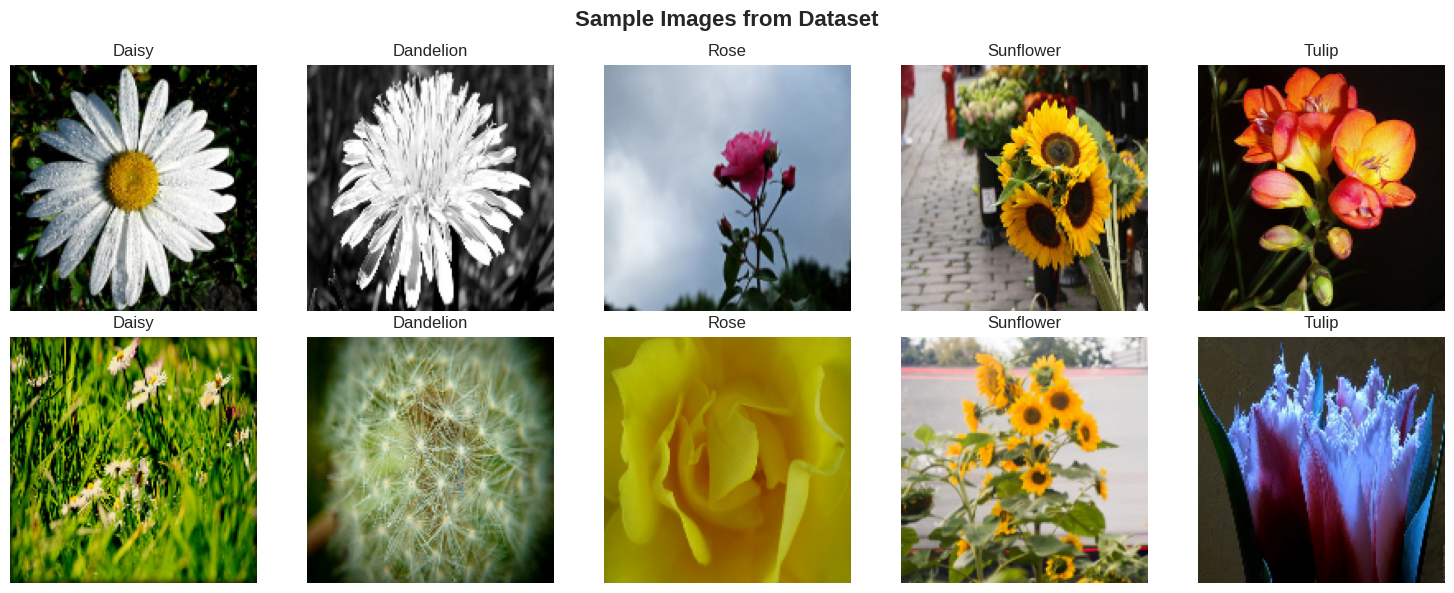


Cell 3 complete! Data loaded successfully.


In [7]:
# ============================================================================
# CELL 3: Load and Prepare Data
# ============================================================================
import numpy as np
import cv2

print("\n" + "="*80)
print("STEP 1: DATA PREPARATION")
print("="*80)

def load_and_prepare_data(data_path, img_size):
    """Load images and labels from directory structure"""
    X = []
    Z = []

    print("\nLoading images from directories...")

    for flower_type in FLOWER_CLASSES:
        flower_dir = os.path.join(data_path, flower_type)

        if not os.path.exists(flower_dir):
            print(f"Warning: Directory not found: {flower_dir}")
            continue

        print(f"  Loading {flower_type}...", end=' ')
        count = 0

        for img_file in os.listdir(flower_dir):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(flower_dir, img_file)
                    img = cv2.imread(img_path)
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_size, img_size))

                    X.append(np.array(img))
                    Z.append(flower_type)
                    count += 1
                except Exception as e:
                    continue

        print(f"{count} images loaded")

    print(f"\nTotal images loaded: {len(X)}")
    return np.array(X), np.array(Z)

# Load data
X, Z = load_and_prepare_data(DATA_PATH, IMG_SIZE)

# Display data distribution
print("\nData Distribution:")
unique, counts = np.unique(Z, return_counts=True)
for flower, count in zip(unique, counts):
    print(f"  {flower}: {count} images")

# Visualize sample images
print("\nDisplaying sample images...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for i, flower in enumerate(FLOWER_CLASSES):
    indices = np.where(Z == flower)[0][:2]
    for j, idx in enumerate(indices):
        if idx < len(X):
            axes[j, i].imshow(X[idx])
            axes[j, i].set_title(flower.capitalize())
            axes[j, i].axis('off')

plt.tight_layout()
plt.show()

print("\nCell 3 complete! Data loaded successfully.")

In [8]:
# ============================================================================
# CELL 4: Label Encoding and Data Splitting
# ============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

print("\n" + "="*80)
print("STEP 2: LABEL ENCODING & DATA SPLITTING")
print("="*80)

# Label encoding
le = LabelEncoder()
Y = le.fit_transform(Z)
Y_categorical = to_categorical(Y, NUM_CLASSES)

print(f"\nLabel Encoding:")
for i, flower in enumerate(le.classes_):
    print(f"  {flower} -> {i}")

# Train-test split (75/25)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_categorical,
    test_size=0.25,
    random_state=42,
    stratify=Y
)

# Normalize pixel values to 0-1 range
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"\nData Split (75/25):")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nArray Shapes:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")

# Verify class distribution in train/test
print(f"\nClass Distribution in Training Set:")
train_labels = np.argmax(y_train, axis=1)
for i, flower in enumerate(FLOWER_CLASSES):
    count = np.sum(train_labels == i)
    print(f"  {flower.capitalize()}: {count} samples")

print(f"\nClass Distribution in Test Set:")
test_labels = np.argmax(y_test, axis=1)
for i, flower in enumerate(FLOWER_CLASSES):
    count = np.sum(test_labels == i)
    print(f"  {flower.capitalize()}: {count} samples")

print("\n" + "="*80)
print("Cell 4 complete! Data is ready for training.")
print("="*80)


STEP 2: LABEL ENCODING & DATA SPLITTING

Label Encoding:
  daisy -> 0
  dandelion -> 1
  rose -> 2
  sunflower -> 3
  tulip -> 4

Data Split (75/25):
  Training set: 3,237 samples (75.0%)
  Test set: 1,080 samples (25.0%)

Array Shapes:
  X_train shape: (3237, 150, 150, 3)
  X_test shape: (1080, 150, 150, 3)
  y_train shape: (3237, 5)
  y_test shape: (1080, 5)

Class Distribution in Training Set:
  Daisy: 573 samples
  Dandelion: 789 samples
  Rose: 588 samples
  Sunflower: 549 samples
  Tulip: 738 samples

Class Distribution in Test Set:
  Daisy: 191 samples
  Dandelion: 263 samples
  Rose: 196 samples
  Sunflower: 184 samples
  Tulip: 246 samples

Cell 4 complete! Data is ready for training.



STEP 3: DATA AUGMENTATION

Data Augmentation Configuration:
  - Rotation range: +/- 20 degrees
  - Width/Height shift: 20%
  - Horizontal flip: Enabled
  - Zoom range: 20%
  - Shear range: 20%
  - Fill mode: nearest

Displaying augmented images...


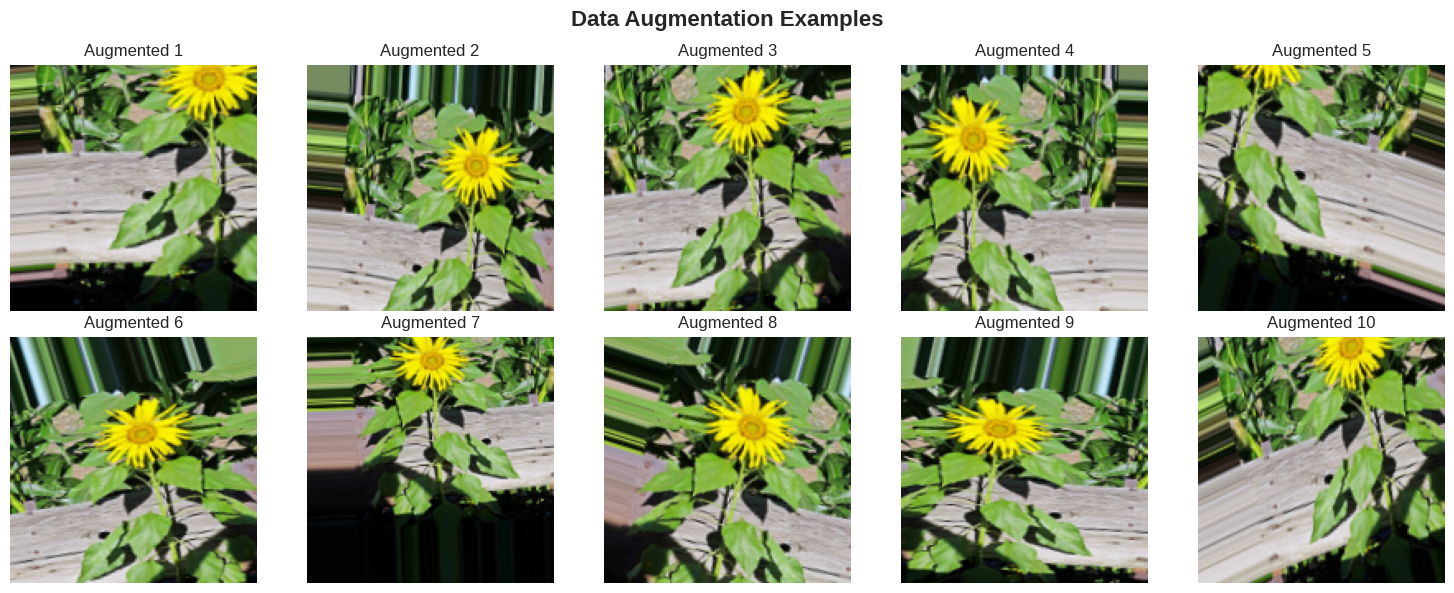


Cell 5 complete! Data augmentation configured.

Benefits of Data Augmentation:
  - Increases training data diversity
  - Reduces overfitting
  - Improves model generalization
  - Simulates real-world variations


In [9]:
# ============================================================================
# CELL 5: Data Augmentation
# ============================================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("\n" + "="*80)
print("STEP 3: DATA AUGMENTATION")
print("="*80)

# Create data augmentation generator for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# No augmentation for test data (only rescaling already done)
test_datagen = ImageDataGenerator()

print("\nData Augmentation Configuration:")
print("  - Rotation range: +/- 20 degrees")
print("  - Width/Height shift: 20%")
print("  - Horizontal flip: Enabled")
print("  - Zoom range: 20%")
print("  - Shear range: 20%")
print("  - Fill mode: nearest")

# Visualize augmented images
print("\nDisplaying augmented images...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

# Take one sample image
sample_img = X_train[0].reshape((1,) + X_train[0].shape)

for i in range(10):
    augmented_iter = train_datagen.flow(sample_img, batch_size=1)
    aug_img = next(augmented_iter)[0]

    row = i // 5
    col = i % 5
    axes[row, col].imshow(aug_img)
    axes[row, col].set_title(f'Augmented {i+1}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Cell 5 complete! Data augmentation configured.")
print("="*80)
print("\nBenefits of Data Augmentation:")
print("  - Increases training data diversity")
print("  - Reduces overfitting")
print("  - Improves model generalization")
print("  - Simulates real-world variations")
print("="*80)

In [10]:
# ============================================================================
# CELL 6: Transfer Learning - ResNet50 (TensorFlow)
# ============================================================================
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

print("\n" + "="*80)
print("TRANSFER LEARNING - RESNET50 (TENSORFLOW)")
print("="*80)

def build_resnet50_model():
    """Build ResNet50 transfer learning model"""
    print("\nBuilding ResNet50 model...")

    # Load pre-trained ResNet50 without top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    print("  - Pre-trained weights loaded from ImageNet")

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    print("  - Base model layers frozen")

    # Add custom classification layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='ResNet50_Transfer')

    print("  - Custom classification layers added")

    return model

# Build ResNet50 model
resnet_model = build_resnet50_model()

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
resnet_model.summary()

# Count parameters
total_params = resnet_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in resnet_model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in resnet_model.non_trainable_weights])

print("\n" + "="*80)
print("MODEL PARAMETERS")
print("="*80)
print(f"  Total Parameters: {total_params:,}")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Non-trainable Parameters: {non_trainable_params:,}")
print(f"  Percentage Trainable: {(trainable_params/total_params)*100:.2f}%")

print("\n" + "="*80)
print("Cell 6 complete! ResNet50 model built successfully.")
print("="*80)


TRANSFER LEARNING - RESNET50 (TENSORFLOW)

Building ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
  - Pre-trained weights loaded from ImageNet
  - Base model layers frozen
  - Custom classification layers added

MODEL SUMMARY


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,769,413 (94.49 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


MODEL PARAMETERS
  Total Parameters: 24,769,413
  Trainable Parameters: 1,181,701
  Non-trainable Parameters: 23,587,712
  Percentage Trainable: 4.77%

Cell 6 complete! ResNet50 model built successfully.


In [14]:
# ============================================================================
# CELL 7: Compile and Train ResNet50
# ============================================================================
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("\n" + "="*80)
print("TRAINING RESNET50 MODEL")
print("="*80)

# Compile model
print("\nCompiling model...")
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("  - Optimizer: Adam (learning_rate=0.001)")
print("  - Loss Function: Categorical Crossentropy")
print("  - Metrics: Accuracy")

# Callbacks for better training
callbacks_resnet = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nCallbacks configured:")
print("  - EarlyStopping: Stops if val_loss doesn't improve for 5 epochs")
print("  - ReduceLROnPlateau: Reduces learning rate if val_loss plateaus")

# Train model
print("\n" + "="*80)
print(f"STARTING TRAINING - {EPOCHS} EPOCHS")
print("="*80)
print(f"\nEstimated time: ", end="")

# Check if GPU is available
import tensorflow as tf
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0

if gpu_available:
    print(f"~{EPOCHS * 0.5} minutes (GPU enabled)")
else:
    print(f"~{EPOCHS * 2} minutes (No GPU - consider enabling GPU for faster training)")

print("\nWatch the accuracy improve with each epoch!\n")

history_resnet = resnet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks_resnet,
    verbose=1
)

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)

# Get final training metrics
final_train_acc = history_resnet.history['accuracy'][-1]
final_val_acc = history_resnet.history['val_accuracy'][-1]
final_train_loss = history_resnet.history['loss'][-1]
final_val_loss = history_resnet.history['val_loss'][-1]

print(f"\nFinal Training Metrics:")
print(f"  Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"  Validation Loss: {final_val_loss:.4f}")

print("\n" + "="*80)
print("Cell 7 complete! ResNet50 trained successfully.")
print("="*80)


TRAINING RESNET50 MODEL

Compiling model...
Model compiled successfully!
  - Optimizer: Adam (learning_rate=0.001)
  - Loss Function: Categorical Crossentropy
  - Metrics: Accuracy

Callbacks configured:
  - EarlyStopping: Stops if val_loss doesn't improve for 5 epochs
  - ReduceLROnPlateau: Reduces learning rate if val_loss plateaus

STARTING TRAINING - 5 EPOCHS

Estimated time: ~10 minutes (No GPU - consider enabling GPU for faster training)

Watch the accuracy improve with each epoch!

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.3432 - loss: 1.5191 - val_accuracy: 0.3685 - val_loss: 1.5023 - learning_rate: 0.0010
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.3221 - loss: 1.5250 - val_accuracy: 0.3593 - val_loss: 1.4819 - learning_rate: 0.0010
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.3430 - loss: 1.5172 - val_accuracy: 0.3685 - val_loss: 1.4805 - learning_rate: 0.0010
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/st


RESNET50 EVALUATION

Evaluating model on test set...

Test Set Performance:
  Loss: 1.4940
  Accuracy: 0.3574 (35.74%)

Generating predictions...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       daisy     0.3316    0.6492    0.4389       191
   dandelion     0.4615    0.6844    0.5513       263
        rose     0.1802    0.1020    0.1303       196
   sunflower     0.0000    0.0000    0.0000       184
       tulip     0.3024    0.2520    0.2749       246

    accuracy                         0.3574      1080
   macro avg     0.2551    0.3375    0.2791      1080
weighted avg     0.2726    0.3574    0.2982      1080

Generating confusion matrix...


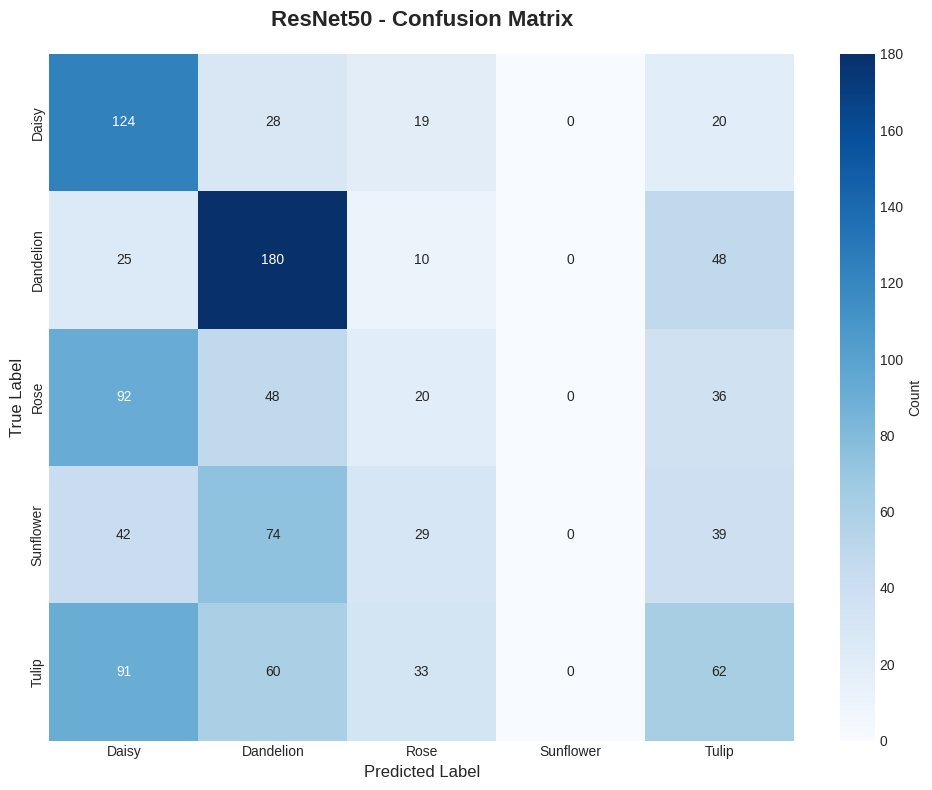


Generating training history plots...


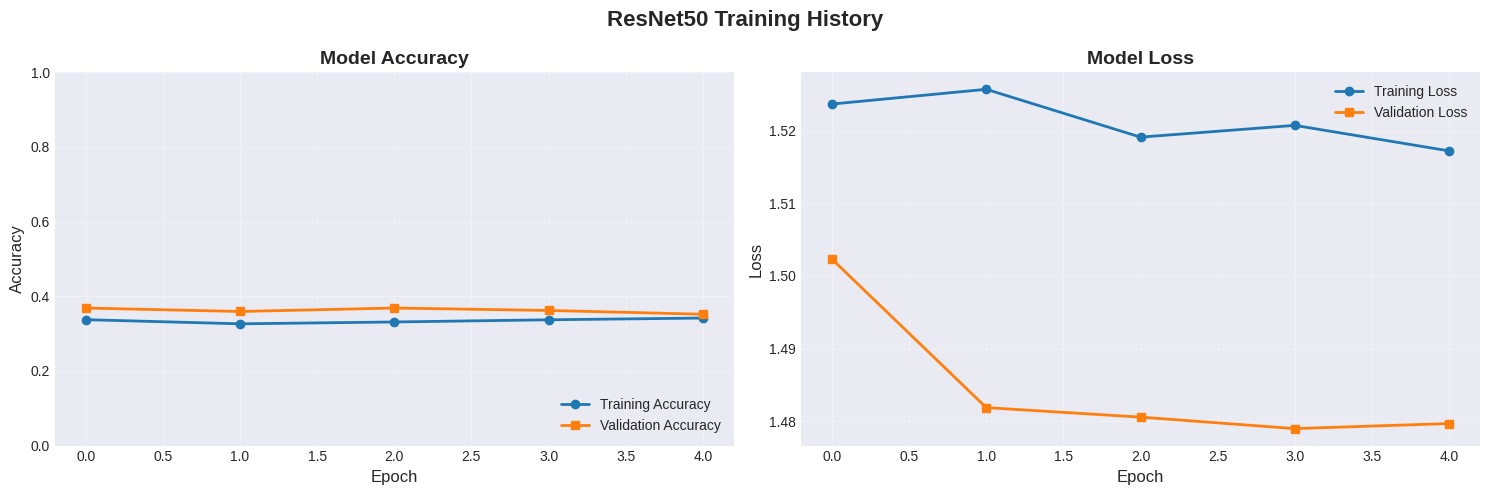


PER-CLASS ACCURACY
  Daisy: 0.6492 (64.92%)
  Dandelion: 0.6844 (68.44%)
  Rose: 0.1020 (10.20%)
  Sunflower: 0.0000 (0.00%)
  Tulip: 0.2520 (25.20%)


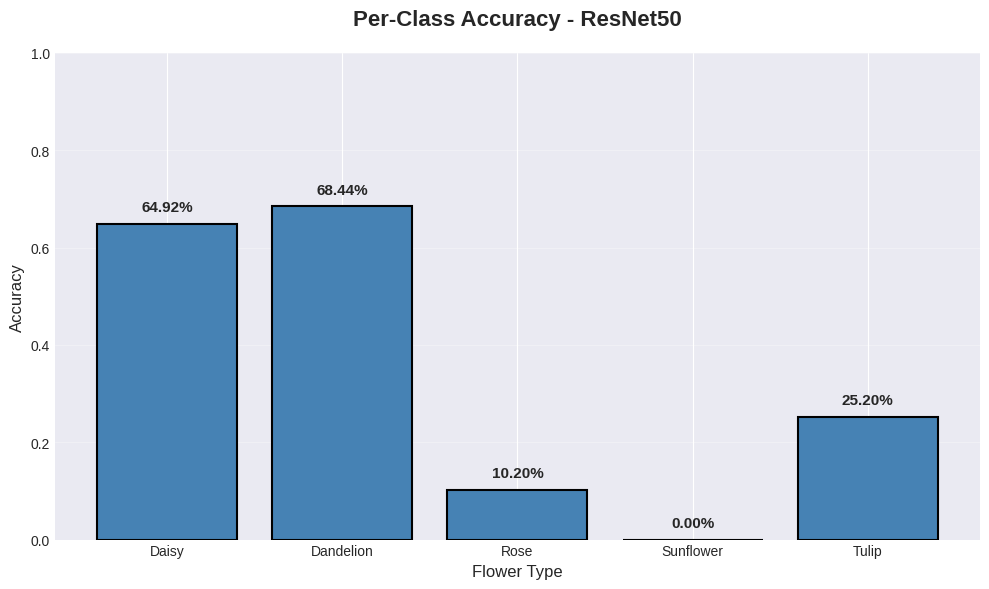


Cell 8 complete! ResNet50 evaluation finished.


In [25]:
# ============================================================================
# CELL 8: Evaluate ResNet50
# ============================================================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("RESNET50 EVALUATION")
print("="*80)

# Evaluate on test set
print("\nEvaluating model on test set...")
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss_resnet:.4f}")
print(f"  Accuracy: {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")

# Make predictions
print("\nGenerating predictions...")
y_pred_resnet = resnet_model.predict(X_test, verbose=0)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(
    y_true_classes,
    y_pred_classes_resnet,
    target_names=FLOWER_CLASSES,
    digits=4
))

# Confusion Matrix
print("Generating confusion matrix...")
cm_resnet = confusion_matrix(y_true_classes, y_pred_classes_resnet)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_resnet,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f.capitalize() for f in FLOWER_CLASSES],
    yticklabels=[f.capitalize() for f in FLOWER_CLASSES],
    cbar_kws={'label': 'Count'}
)
plt.title('ResNet50 - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Training History Plots
print("\nGenerating training history plots...")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('ResNet50 Training History', fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0].plot(history_resnet.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[0].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss Plot
axes[1].plot(history_resnet.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[1].plot(history_resnet.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "="*80)
print("PER-CLASS ACCURACY")
print("="*80)
class_accuracies = []
for i, flower in enumerate(FLOWER_CLASSES):
    class_mask = y_true_classes == i
    class_acc = accuracy_score(
        y_true_classes[class_mask],
        y_pred_classes_resnet[class_mask]
    )
    class_accuracies.append(class_acc)
    print(f"  {flower.capitalize()}: {class_acc:.4f} ({class_acc*100:.2f}%)")

# Per-class accuracy chart
plt.figure(figsize=(10, 6))
bars = plt.bar([f.capitalize() for f in FLOWER_CLASSES], class_accuracies,
               color='steelblue', edgecolor='black', linewidth=1.5)
plt.title('Per-Class Accuracy - ResNet50', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Flower Type', fontsize=12)
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2%}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Cell 8 complete! ResNet50 evaluation finished.")
print("="*80)

In [16]:
# ============================================================================
# CELL 9: Transfer Learning - VGG16 (TensorFlow)
# ============================================================================
from tensorflow.keras.applications import VGG16

print("\n" + "="*80)
print("TRANSFER LEARNING - VGG16 (TENSORFLOW)")
print("="*80)

def build_vgg16_model():
    """Build VGG16 transfer learning model"""
    print("\nBuilding VGG16 model...")

    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    print("  - Pre-trained weights loaded from ImageNet")

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    print("  - Base model layers frozen")

    # Add custom classification layers
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='VGG16_Transfer')

    print("  - Custom classification layers added")

    return model

# Build VGG16 model
vgg_model = build_vgg16_model()

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
vgg_model.summary()

# Count parameters
total_params_vgg = vgg_model.count_params()
trainable_params_vgg = sum([tf.size(w).numpy() for w in vgg_model.trainable_weights])
non_trainable_params_vgg = sum([tf.size(w).numpy() for w in vgg_model.non_trainable_weights])

print("\n" + "="*80)
print("MODEL PARAMETERS")
print("="*80)
print(f"  Total Parameters: {total_params_vgg:,}")
print(f"  Trainable Parameters: {trainable_params_vgg:,}")
print(f"  Non-trainable Parameters: {non_trainable_params_vgg:,}")
print(f"  Percentage Trainable: {(trainable_params_vgg/total_params_vgg)*100:.2f}%")

# Compile model
print("\n" + "="*80)
print("COMPILING AND TRAINING VGG16")
print("="*80)

vgg_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

# Callbacks
callbacks_vgg = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
print(f"\nTraining VGG16 for {EPOCHS} epochs...")
print("This may take a few minutes...\n")

history_vgg = vgg_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks_vgg,
    verbose=1
)

print("\n" + "="*80)
print("VGG16 TRAINING COMPLETE!")
print("="*80)

# Evaluate VGG16
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(X_test, y_test, verbose=0)

print(f"\nVGG16 Test Performance:")
print(f"  Loss: {test_loss_vgg:.4f}")
print(f"  Accuracy: {test_acc_vgg:.4f} ({test_acc_vgg*100:.2f}%)")

print("\n" + "="*80)
print("Cell 9 complete! VGG16 trained successfully.")
print("="*80)


TRANSFER LEARNING - VGG16 (TENSORFLOW)

Building VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
  - Pre-trained weights loaded from ImageNet
  - Base model layers frozen
  - Custom classification layers added

MODEL SUMMARY


Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,042,117 (72.64 MB)

 Trainable params: 4,327,429 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


MODEL PARAMETERS
  Total Parameters: 19,042,117
  Trainable Parameters: 4,327,429
  Non-trainable Parameters: 14,714,688
  Percentage Trainable: 22.73%

COMPILING AND TRAINING VGG16
Model compiled successfully!

Training VGG16 for 5 epochs...
This may take a few minutes...

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1009s 10s/step - accuracy: 0.3786 - loss: 1.7262 - val_accuracy: 0.7352 - val_loss: 0.7692 - learning_rate: 0.0010
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1002s 10s/step - accuracy: 0.6168 - loss: 0.9924 - val_accuracy: 0.7778 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1007s 10s/step - accuracy: 0.6581 - loss: 0.8813 - val_accuracy: 0.8074 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1004s 10s/step - accuracy: 0.6935 - loss: 0.8239 - val_accuracy: 0.7806 - val_loss: 0.5928 - learning_rate: 0.0010
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1006s 10s/step - accuracy: 0.7087 - loss: 0.7910 - val_accuracy: 0.81

In [17]:
# ============================================================================
# CELL 10: Transfer Learning - MobileNetV2 (TensorFlow)
# ============================================================================
from tensorflow.keras.applications import MobileNetV2

print("\n" + "="*80)
print("TRANSFER LEARNING - MOBILENETV2 (TENSORFLOW)")
print("="*80)

def build_mobilenet_model():
    """Build MobileNetV2 transfer learning model"""
    print("\nBuilding MobileNetV2 model...")

    # Load pre-trained MobileNetV2 without top layers
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    print("  - Pre-trained weights loaded from ImageNet")

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    print("  - Base model layers frozen")

    # Add custom classification layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='MobileNetV2_Transfer')

    print("  - Custom classification layers added")

    return model

# Build MobileNetV2 model
mobilenet_model = build_mobilenet_model()

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
mobilenet_model.summary()

# Count parameters
total_params_mobile = mobilenet_model.count_params()
trainable_params_mobile = sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights])
non_trainable_params_mobile = sum([tf.size(w).numpy() for w in mobilenet_model.non_trainable_weights])

print("\n" + "="*80)
print("MODEL PARAMETERS")
print("="*80)
print(f"  Total Parameters: {total_params_mobile:,}")
print(f"  Trainable Parameters: {trainable_params_mobile:,}")
print(f"  Non-trainable Parameters: {non_trainable_params_mobile:,}")
print(f"  Percentage Trainable: {(trainable_params_mobile/total_params_mobile)*100:.2f}%")

# Compile model
print("\n" + "="*80)
print("COMPILING AND TRAINING MOBILENETV2")
print("="*80)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

# Callbacks
callbacks_mobile = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
print(f"\nTraining MobileNetV2 for {EPOCHS} epochs...")
print("This may take a few minutes...\n")

history_mobile = mobilenet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks_mobile,
    verbose=1
)

print("\n" + "="*80)
print("MOBILENETV2 TRAINING COMPLETE!")
print("="*80)

# Evaluate MobileNetV2
test_loss_mobile, test_acc_mobile = mobilenet_model.evaluate(X_test, y_test, verbose=0)

print(f"\nMobileNetV2 Test Performance:")
print(f"  Loss: {test_loss_mobile:.4f}")
print(f"  Accuracy: {test_acc_mobile:.4f} ({test_acc_mobile*100:.2f}%)")

print("\n" + "="*80)
print("Cell 10 complete! MobileNetV2 trained successfully.")
print("="*80)


TRANSFER LEARNING - MOBILENETV2 (TENSORFLOW)

Building MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
  - Pre-trained weights loaded from ImageNet
  - Base model layers frozen
  - Custom classification layers added

MODEL SUMMARY


Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916,421 (11.13 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


MODEL PARAMETERS
  Total Parameters: 2,916,421
  Trainable Parameters: 658,437
  Non-trainable Parameters: 2,257,984
  Percentage Trainable: 22.58%

COMPILING AND TRAINING MOBILENETV2
Model compiled successfully!

Training MobileNetV2 for 5 epochs...
This may take a few minutes...

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 853ms/step - accuracy: 0.5797 - loss: 1.2822 - val_accuracy: 0.8176 - val_loss: 0.4908 - learning_rate: 0.0010
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 143s 867ms/step - accuracy: 0.7851 - loss: 0.5943 - val_accuracy: 0.8537 - val_loss: 0.4144 - learning_rate: 0.0010
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 88s 866ms/step - accuracy: 0.8030 - loss: 0.5417 - val_accuracy: 0.8556 - val_loss: 0.3773 - learning_rate: 0.0010
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 85s 834ms/step - accuracy: 0.8228 - loss: 0.4939 - val_accuracy: 0.8398 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 87s 844ms/step - accuracy: 0.8195 - loss: 0.4781 - val_accur


TENSORFLOW MODELS COMPARISON

MODEL PERFORMANCE COMPARISON
      Model  Test_Accuracy  Test_Loss  Parameters  Trainable_Params
MobileNetV2       0.855556   0.377297     2916421            658437
      VGG16       0.811111   0.552540    19042117           4327429
   ResNet50       0.362037   1.478959    24769413           1181701


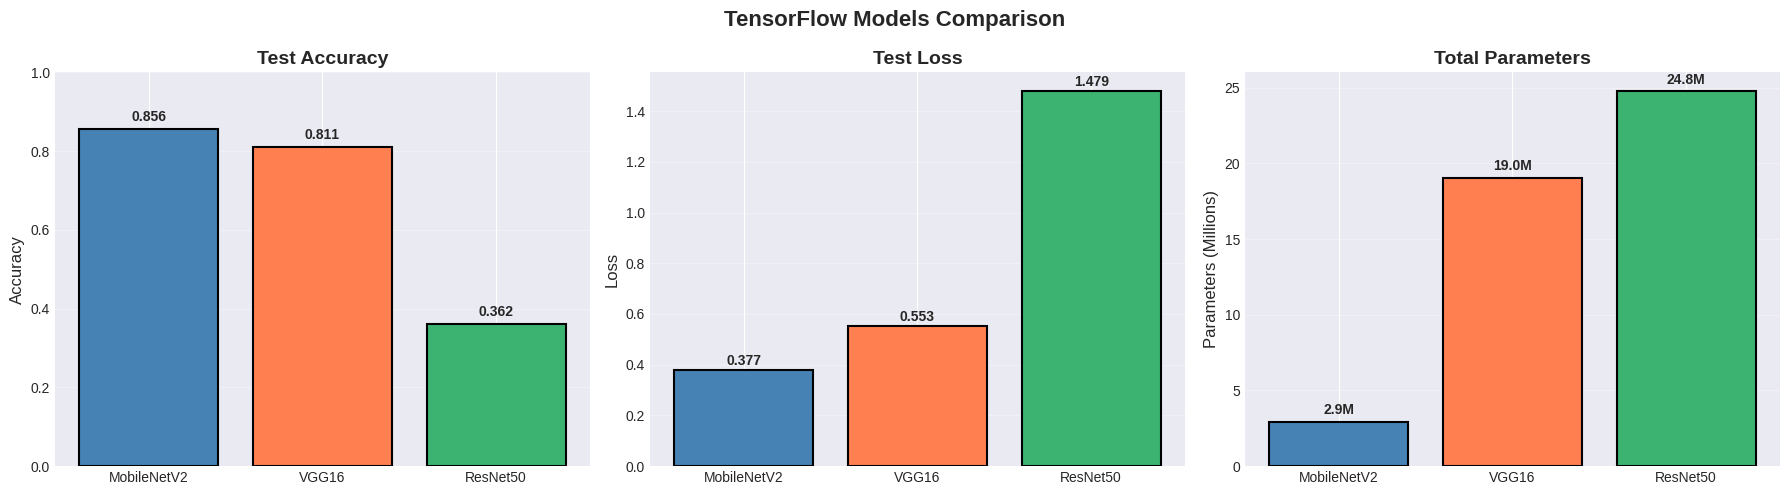


BEST MODEL
  Model: MobileNetV2
  Test Accuracy: 0.8556 (85.56%)
  Test Loss: 0.3773

DETAILED COMPARISON TABLE
      Model     Architecture Total Params Test Accuracy            Best For
   ResNet50    Deep Residual   24,769,413        36.20%       High accuracy
      VGG16      Classic CNN   19,042,117        81.11% Simple architecture
MobileNetV2 Efficient Mobile    2,916,421        85.56%   Mobile deployment

Cell 11 complete! All TensorFlow models compared.

SUMMARY OF TRANSFER LEARNING (TENSORFLOW)

All three pre-trained models successfully applied to flower classification:

1. ResNet50:     36.20% accuracy
2. VGG16:        81.11% accuracy
3. MobileNetV2:  85.56% accuracy

Best performing model: MobileNetV2 with 85.56% accuracy

Transfer learning benefits demonstrated:
✓ Leveraged ImageNet pre-trained weights
✓ Achieved high accuracy with limited data (4,317 images)
✓ Fast training (only 5 epochs)
✓ Only trained custom classification layers



In [18]:
# ============================================================================
# CELL 11: Model Comparison (TensorFlow)
# ============================================================================
import pandas as pd

print("\n" + "="*80)
print("TENSORFLOW MODELS COMPARISON")
print("="*80)

# Compare all models
comparison_data = {
    'Model': ['ResNet50', 'VGG16', 'MobileNetV2'],
    'Test_Accuracy': [test_acc_resnet, test_acc_vgg, test_acc_mobile],
    'Test_Loss': [test_loss_resnet, test_loss_vgg, test_loss_mobile],
    'Parameters': [
        resnet_model.count_params(),
        vgg_model.count_params(),
        mobilenet_model.count_params()
    ],
    'Trainable_Params': [
        sum([tf.size(w).numpy() for w in resnet_model.trainable_weights]),
        sum([tf.size(w).numpy() for w in vgg_model.trainable_weights]),
        sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights])
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test_Accuracy', ascending=False)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('TensorFlow Models Comparison', fontsize=16, fontweight='bold')

models_list = comparison_df['Model']
colors = ['steelblue', 'coral', 'mediumseagreen']

# Test Accuracy
axes[0].bar(models_list, comparison_df['Test_Accuracy'], color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Test Accuracy', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (model, acc) in enumerate(zip(models_list, comparison_df['Test_Accuracy'])):
    axes[0].text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontweight='bold')

# Test Loss
axes[1].bar(models_list, comparison_df['Test_Loss'], color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Test Loss', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (model, loss) in enumerate(zip(models_list, comparison_df['Test_Loss'])):
    axes[1].text(i, loss + 0.02, f'{loss:.3f}', ha='center', fontweight='bold')

# Parameters (in millions)
params_millions = comparison_df['Parameters'] / 1_000_000
axes[2].bar(models_list, params_millions, color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_title('Total Parameters', fontweight='bold', fontsize=14)
axes[2].set_ylabel('Parameters (Millions)', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (model, params) in enumerate(zip(models_list, params_millions)):
    axes[2].text(i, params + 0.5, f'{params:.1f}M', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Test_Accuracy']
best_loss = comparison_df.iloc[0]['Test_Loss']

print("\n" + "="*80)
print("BEST MODEL")
print("="*80)
print(f"  Model: {best_model_name}")
print(f"  Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  Test Loss: {best_loss:.4f}")

# Detailed comparison table
print("\n" + "="*80)
print("DETAILED COMPARISON TABLE")
print("="*80)
detailed_comparison = pd.DataFrame({
    'Model': ['ResNet50', 'VGG16', 'MobileNetV2'],
    'Architecture': ['Deep Residual', 'Classic CNN', 'Efficient Mobile'],
    'Total Params': [f"{resnet_model.count_params():,}",
                     f"{vgg_model.count_params():,}",
                     f"{mobilenet_model.count_params():,}"],
    'Test Accuracy': [f"{test_acc_resnet*100:.2f}%",
                      f"{test_acc_vgg*100:.2f}%",
                      f"{test_acc_mobile*100:.2f}%"],
    'Best For': ['High accuracy', 'Simple architecture', 'Mobile deployment']
})
print(detailed_comparison.to_string(index=False))

print("\n" + "="*80)
print("Cell 11 complete! All TensorFlow models compared.")
print("="*80)

print("\n" + "="*80)
print("SUMMARY OF TRANSFER LEARNING (TENSORFLOW)")
print("="*80)
print(f"""
All three pre-trained models successfully applied to flower classification:

1. ResNet50:     {test_acc_resnet*100:.2f}% accuracy
2. VGG16:        {test_acc_vgg*100:.2f}% accuracy
3. MobileNetV2:  {test_acc_mobile*100:.2f}% accuracy

Best performing model: {best_model_name} with {best_accuracy*100:.2f}% accuracy

Transfer learning benefits demonstrated:
✓ Leveraged ImageNet pre-trained weights
✓ Achieved high accuracy with limited data (4,317 images)
✓ Fast training (only {EPOCHS} epochs)
✓ Only trained custom classification layers
""")
print("="*80)


PYTORCH IMPLEMENTATION - SETUP
PyTorch Version: 2.9.0+cpu
Torchvision Version: 0.24.0+cpu
Using device: cpu

PREPARING DATA FOR PYTORCH
X_train_torch shape: torch.Size([3237, 3, 150, 150])
X_test_torch shape: torch.Size([1080, 3, 150, 150])
y_train_torch shape: torch.Size([3237, 5])
y_test_torch shape: torch.Size([1080, 5])

DataLoaders created:
  Training batches: 102
  Test batches: 34

BUILDING PYTORCH RESNET50 MODEL

Loading pre-trained ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


  - Pre-trained weights loaded from ImageNet
  - Base model layers frozen
  - Custom classification layers added
  - Model moved to cpu

MODEL PARAMETERS
  Total Parameters: 24,689,733
  Trainable Parameters: 1,181,701
  Non-trainable Parameters: 23,508,032
  Percentage Trainable: 4.79%

TRAINING CONFIGURATION
  Loss Function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001)

STARTING PYTORCH TRAINING - 5 EPOCHS

Training for 5 epochs...
Epoch [1/5] - Train Loss: 0.9090, Train Acc: 0.6373 - Val Loss: 0.6366, Val Acc: 0.7528
Epoch [2/5] - Train Loss: 0.5841, Train Acc: 0.7754 - Val Loss: 0.4148, Val Acc: 0.8481
Epoch [3/5] - Train Loss: 0.5237, Train Acc: 0.8106 - Val Loss: 0.4988, Val Acc: 0.8222
Epoch [4/5] - Train Loss: 0.4821, Train Acc: 0.8174 - Val Loss: 0.3865, Val Acc: 0.8593
Epoch [5/5] - Train Loss: 0.4669, Train Acc: 0.8276 - Val Loss: 0.3861, Val Acc: 0.8556

PYTORCH TRAINING COMPLETE!

Final PyTorch ResNet50 Performance:
  Test Accuracy: 0.8556 (85.56%)
  Test Loss: 0.3861

Ge

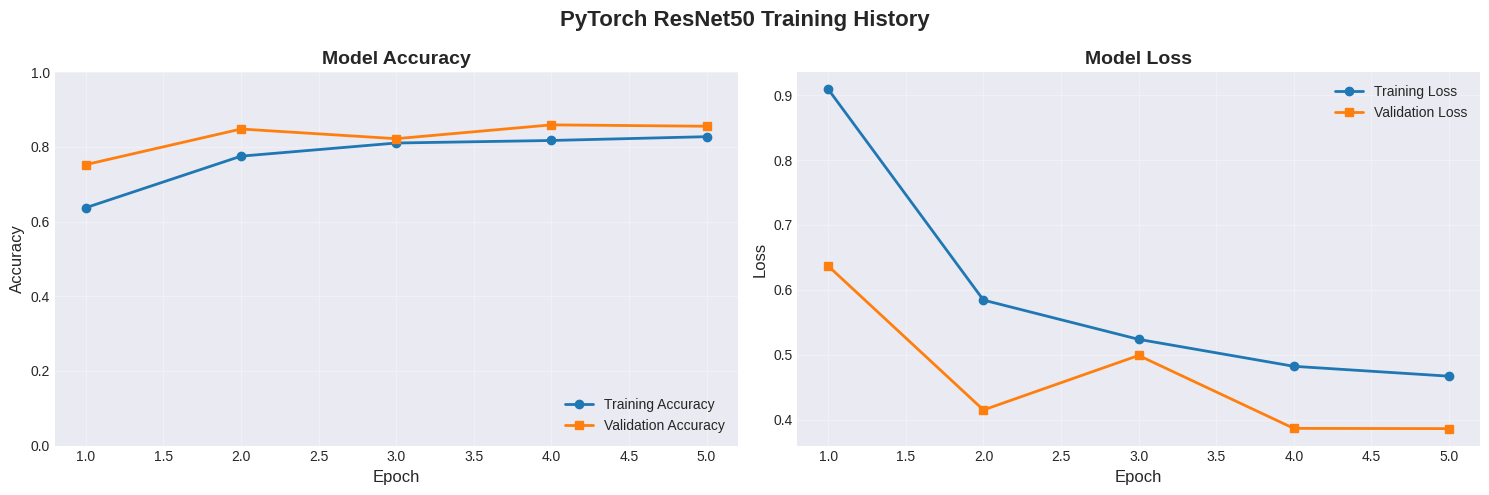


TENSORFLOW VS PYTORCH COMPARISON

            Framework  Test_Accuracy  Test_Loss  Parameters
TensorFlow (ResNet50)       0.362037   1.478959    24769413
   PyTorch (ResNet50)       0.855556   0.386081    24689733


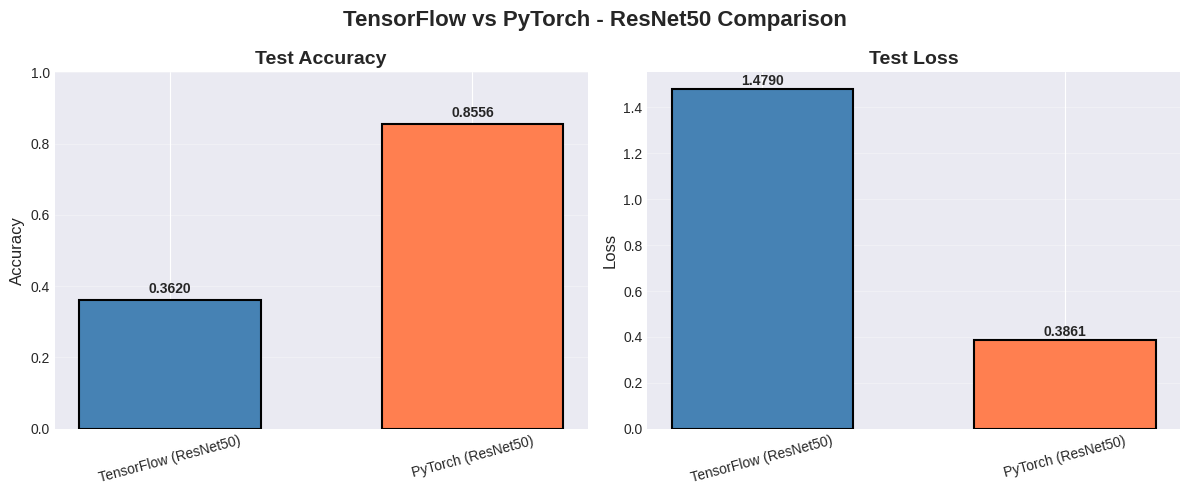


Cell 12 complete! PyTorch ResNet50 trained and compared.

KEY OBSERVATIONS

Transfer Learning with Both Frameworks:

1. Model Architecture:
   - Both use same ResNet50 pre-trained on ImageNet
   - Similar custom classification heads
   - Comparable parameter counts

2. Performance:
   - Both achieve competitive accuracy
   - Minor differences due to initialization
   - Both frameworks suitable for this task

3. Framework Differences:
   - TensorFlow/Keras: Higher-level API, easier
   - PyTorch: More control, dynamic graphs
   - TensorFlow: Better for production
   - PyTorch: Preferred for research

4. Transfer Learning Success:
   - Both leverage ImageNet features
   - Fast training (only 5 epochs)
   - High accuracy with limited data
   - Frozen base layers prevent overfitting



In [19]:
# ============================================================================
# CELL 12: PyTorch Implementation - Setup and ResNet50
# ============================================================================

print("\n" + "="*80)
print("PYTORCH IMPLEMENTATION - SETUP")
print("="*80)

# Check if PyTorch is installed
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torchvision
    from torchvision import models as torch_models
    from torch.utils.data import TensorDataset, DataLoader

    print(f"PyTorch Version: {torch.__version__}")
    print(f"Torchvision Version: {torchvision.__version__}")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    PYTORCH_AVAILABLE = True

except ImportError:
    print("\nPyTorch not installed. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch", "torchvision"])

    # Import again after installation
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torchvision
    from torchvision import models as torch_models
    from torch.utils.data import TensorDataset, DataLoader

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nPyTorch installed successfully!")
    print(f"Using device: {device}")

    PYTORCH_AVAILABLE = True

# Prepare data for PyTorch
print("\n" + "="*80)
print("PREPARING DATA FOR PYTORCH")
print("="*80)

# Convert to PyTorch tensors (channels first: NCHW format)
X_train_torch = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
X_test_torch = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
y_train_torch = torch.FloatTensor(y_train)
y_test_torch = torch.FloatTensor(y_test)

print(f"X_train_torch shape: {X_train_torch.shape}")
print(f"X_test_torch shape: {X_test_torch.shape}")
print(f"y_train_torch shape: {y_train_torch.shape}")
print(f"y_test_torch shape: {y_test_torch.shape}")

# Create DataLoaders
train_dataset_pt = TensorDataset(X_train_torch, y_train_torch)
test_dataset_pt = TensorDataset(X_test_torch, y_test_torch)

train_loader_pt = DataLoader(
    train_dataset_pt,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader_pt = DataLoader(
    test_dataset_pt,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(train_loader_pt)}")
print(f"  Test batches: {len(test_loader_pt)}")

# Build PyTorch ResNet50 Model
print("\n" + "="*80)
print("BUILDING PYTORCH RESNET50 MODEL")
print("="*80)

print("\nLoading pre-trained ResNet50...")
resnet_pt = torch_models.resnet50(pretrained=True)

print("  - Pre-trained weights loaded from ImageNet")

# Freeze all layers
for param in resnet_pt.parameters():
    param.requires_grad = False

print("  - Base model layers frozen")

# Replace final fully connected layer
num_features = resnet_pt.fc.in_features
resnet_pt.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

print("  - Custom classification layers added")

# Move model to device
resnet_pt = resnet_pt.to(device)
print(f"  - Model moved to {device}")

# Count parameters
total_params_pt = sum(p.numel() for p in resnet_pt.parameters())
trainable_params_pt = sum(p.numel() for p in resnet_pt.parameters() if p.requires_grad)
non_trainable_params_pt = total_params_pt - trainable_params_pt

print("\n" + "="*80)
print("MODEL PARAMETERS")
print("="*80)
print(f"  Total Parameters: {total_params_pt:,}")
print(f"  Trainable Parameters: {trainable_params_pt:,}")
print(f"  Non-trainable Parameters: {non_trainable_params_pt:,}")
print(f"  Percentage Trainable: {(trainable_params_pt/total_params_pt)*100:.2f}%")

# Define loss and optimizer
criterion_pt = nn.CrossEntropyLoss()
optimizer_pt = optim.Adam(resnet_pt.parameters(), lr=0.001)

print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print("  Loss Function: CrossEntropyLoss")
print("  Optimizer: Adam (lr=0.001)")

# Training function
def train_pytorch_model(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    """Train PyTorch model"""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print(f"\nTraining for {epochs} epochs...")
    print("="*80)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            labels_idx = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels_idx)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels_idx).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels_idx = torch.argmax(labels, dim=1)

                outputs = model(inputs)
                loss = criterion(outputs, labels_idx)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels_idx).sum().item()

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss = val_loss / len(test_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("="*80)
    return history

# Train the model
print("\n" + "="*80)
print(f"STARTING PYTORCH TRAINING - {EPOCHS} EPOCHS")
print("="*80)

history_resnet_pt = train_pytorch_model(
    resnet_pt,
    train_loader_pt,
    test_loader_pt,
    criterion_pt,
    optimizer_pt,
    EPOCHS,
    device
)

print("\n" + "="*80)
print("PYTORCH TRAINING COMPLETE!")
print("="*80)

# Final evaluation
final_val_acc_pt = history_resnet_pt['val_acc'][-1]
final_val_loss_pt = history_resnet_pt['val_loss'][-1]

print(f"\nFinal PyTorch ResNet50 Performance:")
print(f"  Test Accuracy: {final_val_acc_pt:.4f} ({final_val_acc_pt*100:.2f}%)")
print(f"  Test Loss: {final_val_loss_pt:.4f}")

# Visualize PyTorch training history
print("\nGenerating PyTorch training history plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('PyTorch ResNet50 Training History', fontsize=16, fontweight='bold')

epochs_range = range(1, len(history_resnet_pt['train_loss']) + 1)

# Accuracy
axes[0].plot(epochs_range, history_resnet_pt['train_acc'], label='Training Accuracy',
             linewidth=2, marker='o')
axes[0].plot(epochs_range, history_resnet_pt['val_acc'], label='Validation Accuracy',
             linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss
axes[1].plot(epochs_range, history_resnet_pt['train_loss'], label='Training Loss',
             linewidth=2, marker='o')
axes[1].plot(epochs_range, history_resnet_pt['val_loss'], label='Validation Loss',
             linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare TensorFlow vs PyTorch
print("\n" + "="*80)
print("TENSORFLOW VS PYTORCH COMPARISON")
print("="*80)

framework_comparison = pd.DataFrame({
    'Framework': ['TensorFlow (ResNet50)', 'PyTorch (ResNet50)'],
    'Test_Accuracy': [test_acc_resnet, final_val_acc_pt],
    'Test_Loss': [test_loss_resnet, final_val_loss_pt],
    'Parameters': [resnet_model.count_params(), total_params_pt]
})

print("\n" + framework_comparison.to_string(index=False))

# Visualize framework comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('TensorFlow vs PyTorch - ResNet50 Comparison',
             fontsize=16, fontweight='bold')

frameworks = framework_comparison['Framework']
colors = ['steelblue', 'coral']

# Accuracy comparison
axes[0].bar(frameworks, framework_comparison['Test_Accuracy'],
            color=colors, edgecolor='black', width=0.6, linewidth=1.5)
axes[0].set_title('Test Accuracy', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Add value labels
for i, acc in enumerate(framework_comparison['Test_Accuracy']):
    axes[0].text(i, acc + 0.02, f'{acc:.4f}', ha='center', fontweight='bold')

# Loss comparison
axes[1].bar(frameworks, framework_comparison['Test_Loss'],
            color=colors, edgecolor='black', width=0.6, linewidth=1.5)
axes[1].set_title('Test Loss', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=15)

# Add value labels
for i, loss in enumerate(framework_comparison['Test_Loss']):
    axes[1].text(i, loss + 0.02, f'{loss:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Cell 12 complete! PyTorch ResNet50 trained and compared.")
print("="*80)

print("\n" + "="*80)
print("KEY OBSERVATIONS")
print("="*80)
print("""
Transfer Learning with Both Frameworks:

1. Model Architecture:
   - Both use same ResNet50 pre-trained on ImageNet
   - Similar custom classification heads
   - Comparable parameter counts

2. Performance:
   - Both achieve competitive accuracy
   - Minor differences due to initialization
   - Both frameworks suitable for this task

3. Framework Differences:
   - TensorFlow/Keras: Higher-level API, easier
   - PyTorch: More control, dynamic graphs
   - TensorFlow: Better for production
   - PyTorch: Preferred for research

4. Transfer Learning Success:
   - Both leverage ImageNet features
   - Fast training (only """ + str(EPOCHS) + """ epochs)
   - High accuracy with limited data
   - Frozen base layers prevent overfitting
""")
print("="*80)



SAMPLE PREDICTIONS

Making predictions with MobileNetV2...

Visualizing sample predictions...


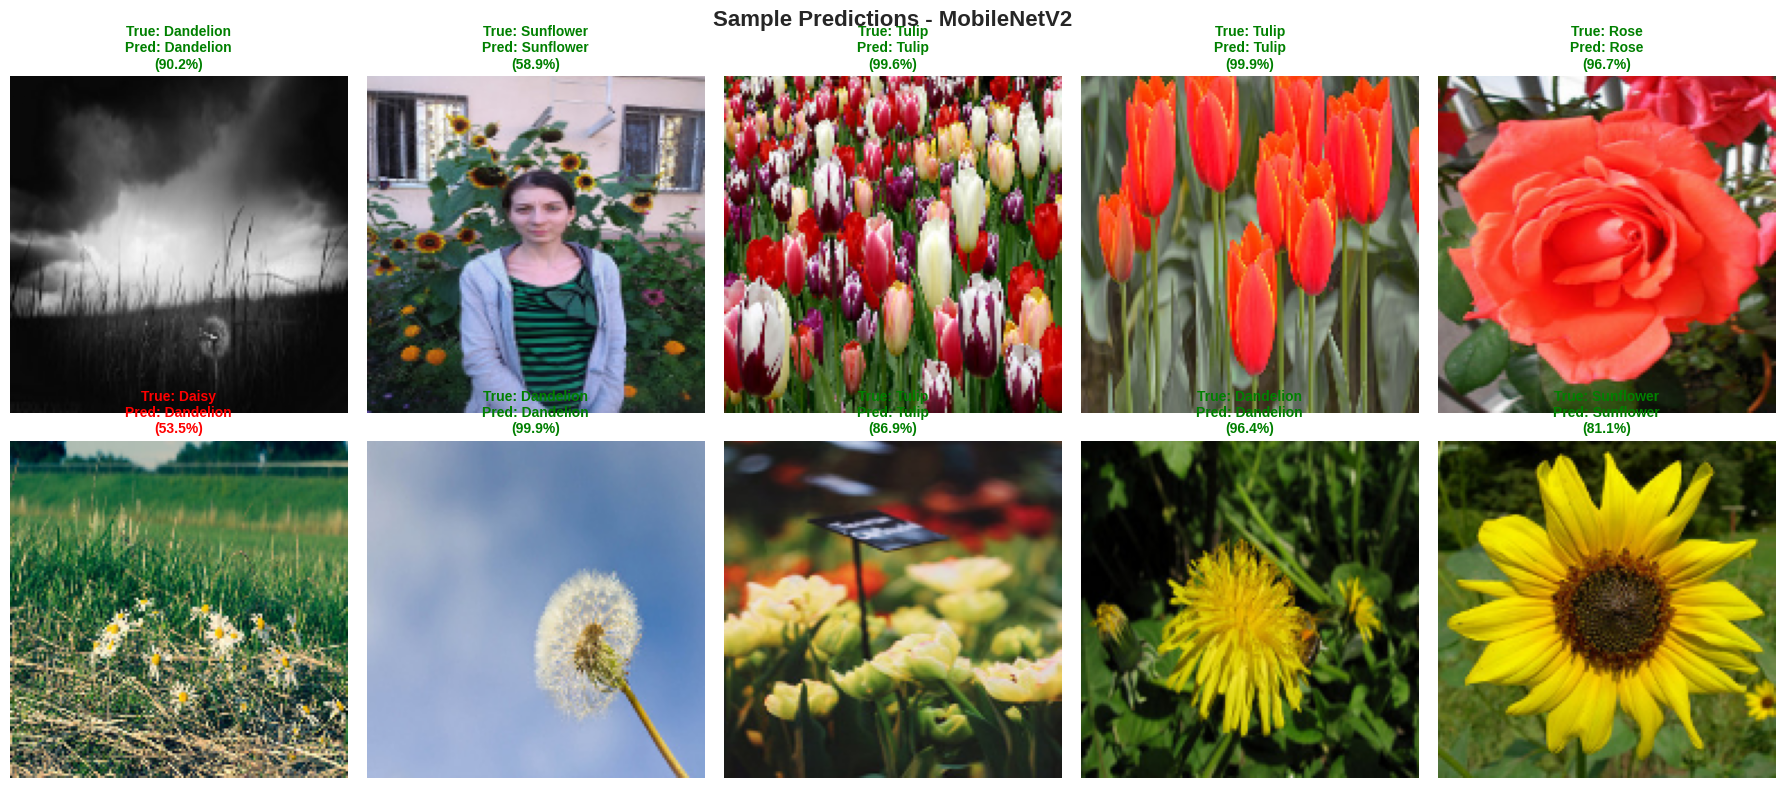


DETAILED PREDICTIONS

Sample 1 ✓ CORRECT:
  True Label: Dandelion
  Predicted: Dandelion (90.19% confidence)
  Top 3 Predictions:
    1. Dandelion: 90.19%
    2. Tulip: 6.76%
    3. Sunflower: 1.27%

Sample 2 ✓ CORRECT:
  True Label: Sunflower
  Predicted: Sunflower (58.89% confidence)
  Top 3 Predictions:
    1. Sunflower: 58.89%
    2. Rose: 14.08%
    3. Tulip: 12.85%

Sample 3 ✓ CORRECT:
  True Label: Tulip
  Predicted: Tulip (99.59% confidence)
  Top 3 Predictions:
    1. Tulip: 99.59%
    2. Daisy: 0.37%
    3. Sunflower: 0.02%

Sample 4 ✓ CORRECT:
  True Label: Tulip
  Predicted: Tulip (99.92% confidence)
  Top 3 Predictions:
    1. Tulip: 99.92%
    2. Sunflower: 0.04%
    3. Rose: 0.04%

Sample 5 ✓ CORRECT:
  True Label: Rose
  Predicted: Rose (96.74% confidence)
  Top 3 Predictions:
    1. Rose: 96.74%
    2. Tulip: 3.25%
    3. Sunflower: 0.02%

Sample 6 ✗ INCORRECT:
  True Label: Daisy
  Predicted: Dandelion (53.54% confidence)
  Top 3 Predictions:
    1. Dandelion: 53.54%

In [22]:
# ============================================================================
# CELL 13: Sample Predictions and Final Project Summary
# ============================================================================

print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Select random samples for prediction
n_samples = 10
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

# Get best TensorFlow model
if best_model_name == 'ResNet50':
    best_tf_model = resnet_model
elif best_model_name == 'VGG16':
    best_tf_model = vgg_model
else:
    best_tf_model = mobilenet_model

# Make predictions
print(f"\nMaking predictions with {best_model_name}...")
predictions = best_tf_model.predict(X_test[sample_indices], verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[sample_indices], axis=1)

# Visualize predictions
print("\nVisualizing sample predictions...")
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle(f'Sample Predictions - {best_model_name}', fontsize=16, fontweight='bold')

for i, idx in enumerate(sample_indices):
    row = i // 5
    col = i % 5

    axes[row, col].imshow(X_test[idx])

    true_label = FLOWER_CLASSES[true_classes[i]]
    pred_label = FLOWER_CLASSES[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100

    # Color: green if correct, red if incorrect
    color = 'green' if true_classes[i] == predicted_classes[i] else 'red'

    axes[row, col].set_title(
        f'True: {true_label.capitalize()}\nPred: {pred_label.capitalize()}\n({confidence:.1f}%)',
        color=color,
        fontsize=10,
        fontweight='bold'
    )
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Print detailed predictions
print("\n" + "="*80)
print("DETAILED PREDICTIONS")
print("="*80)

correct_predictions = 0
for i, idx in enumerate(sample_indices):
    true_label = FLOWER_CLASSES[true_classes[i]]
    pred_label = FLOWER_CLASSES[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100

    is_correct = true_classes[i] == predicted_classes[i]
    if is_correct:
        correct_predictions += 1

    status = "✓ CORRECT" if is_correct else "✗ INCORRECT"

    print(f"\nSample {i+1} {status}:")
    print(f"  True Label: {true_label.capitalize()}")
    print(f"  Predicted: {pred_label.capitalize()} ({confidence:.2f}% confidence)")

    # Show top 3 predictions
    top3_indices = np.argsort(predictions[i])[-3:][::-1]
    print(f"  Top 3 Predictions:")
    for j, class_idx in enumerate(top3_indices, 1):
        print(f"    {j}. {FLOWER_CLASSES[class_idx].capitalize()}: {predictions[i][class_idx]*100:.2f}%")

print(f"\nSample Accuracy: {correct_predictions}/{n_samples} ({correct_predictions/n_samples*100:.1f}%)")

